<a href="https://colab.research.google.com/github/wayne0git/signal_image_process/blob/main/jpeg_encode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG Encode
- Ref : https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Constant

In [15]:
# JPEG Block size
B = 8

# JPEG Quality factor
QF = 10.0   # 1 ~ 99

In [16]:
# Quantization Table (Luma / Chroma)
QY=np.array([[16,11,10,16,24,40,51,61],
      [12,12,14,19,26,48,60,55],
      [14,13,16,24,40,57,69,56],
      [14,17,22,29,51,87,80,62],
      [18,22,37,56,68,109,103,77],
      [24,35,55,64,81,104,113,92],
      [49,64,78,87,103,121,120,101],
      [72,92,95,98,112,100,103,99]])

QC=np.array([[17,18,24,47,99,99,99,99],
      [18,21,26,66,99,99,99,99],
      [24,26,56,99,99,99,99,99],
      [47,66,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99]])

## 1. Read data

In [17]:
img = cv2.imread('lena.jpg')

In [18]:
# Crop image to integer multiples of block size (Multiply 2 due to chroma subsample)
n_row, n_col = img.shape[:2]
img = img[:(n_row // (B * 2)) * (B * 2), :(n_col // (B * 2)) * (B * 2)]

## 2. Color Conversion (RGB => YCbCr) (With chroma subsample, 420)

In [19]:
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

In [20]:
# Apply 2 * 2 average before 2x subsample
cr_sub = cv2.boxFilter(img_ycrcb[..., 1], ddepth=-1, ksize=(2, 2))[::2, ::2]
cb_sub = cv2.boxFilter(img_ycrcb[..., 2], ddepth=-1, ksize=(2, 2))[::2, ::2]

In [21]:
# Concatenate Y / Cr / Cb
ycrcb = [img_ycrcb[..., 0], cr_sub, cb_sub]

## 3. DCT & Quantization

In [22]:
# Adjust quantization table based on quality factor
def get_scale(qf):
    if qf < 50 and qf >= 1:
        return np.floor(5000 / qf) / 100.0
    elif qf < 100:
        return (200 - 2 * qf) / 100.0
    else:
        print('Quality Factor must be in the range [1..99]')
        return 1

scale = get_scale(QF)
q_table = [QY * scale, QC * scale, QC * scale]

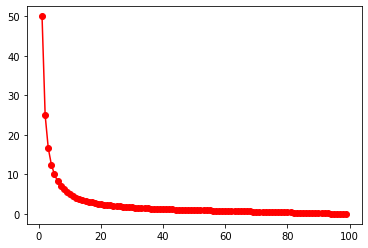

In [23]:
plt.plot(range(1, 100), [get_scale(q) for q in range(1, 100)], 'ro-')

In [24]:
# Apply DCT and quantization
ycrcb_q = []

for ind, channel in enumerate(ycrcb):
    n_row, n_col = channel.shape[:2]
    n_blk_row, n_blk_col = n_row // B, n_col // B

    # Normalization (0 ~ 255 => -128 ~ 127)
    channel_n = channel.copy().astype(np.float32)
    channel_n = channel_n - 128

    # DCT & Quantization
    quan = np.zeros((n_row, n_col), np.float32)
    for rid in range(n_blk_row):
        for cid in range(n_blk_col):
            # DCT
            dct_blk = cv2.dct(channel_n[rid * B:(rid + 1) * B, cid * B:(cid + 1) * B])

            # Quantization
            quan[rid * B:(rid + 1) * B, cid * B:(cid + 1) * B] = np.round(dct_blk / q_table[ind])
    ycrcb_q.append(quan)

## 4. Decode for visualization

In [25]:
# JPEG Decode
img_ycrcb_jpg = np.zeros_like(img)

for ind, channel in enumerate(ycrcb_q):
    n_row, n_col = channel.shape[:2]
    n_blk_row, n_blk_col = n_row // B, n_col // B

    channel_jpg = np.zeros((n_row, n_col), np.uint8)
    for rid in range(n_blk_row):
        for cid in range(n_blk_col):
            # De-quantize
            dct_blk = channel[rid * B:(rid + 1) * B, cid * B:(cid + 1) * B] * q_table[ind]

            # Inverse DCT & De-normalization
            cur_blk = np.round(cv2.idct(dct_blk)) + 128
            cur_blk = np.clip(cur_blk, 0, 255)
            channel_jpg[rid * B:(rid + 1) * B, cid * B:(cid + 1) * B] = cur_blk

    # Chroma Upsample
    channel_jpg = cv2.resize(channel_jpg, (img.shape[1], img.shape[0]))
    img_ycrcb_jpg[..., ind] = np.round(channel_jpg)

# Color conversion (YCrCb => BGR)
img_bgr_jpg = cv2.cvtColor(img_ycrcb_jpg, cv2.COLOR_YCR_CB2BGR)

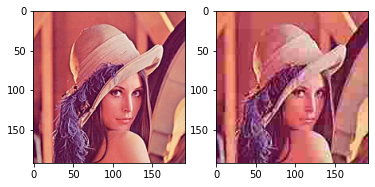

In [26]:
# Visualize JPEG encode result
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_bgr_jpg, cv2.COLOR_BGR2RGB))